# Gauge Observables

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = 5 * ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = 5 * ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'P', 'D']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

In [2]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [3]:
from lattice.lattice import GaugeLattice, u1_plaq_exact
from l2hmc_eager import gauge_dynamics_eager as gde
from gauge_model import GaugeModel, save_params_to_pkl_file

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib inline

In [4]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [5]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Calculate and plot observables...

### Calculate observables for samples generated during **_training_**:
- Every $\approx 500$ steps or so during training procedure, we run the sampler at $\beta \equiv \beta_{\mathrm{final}}$. 
- By calculating observables (``total action``, ``average plaquette``, and ``topological charge``) for these samples and looking at the ``thermalization time``, we can get an idea of how well the sampler is performing.
- We expect that as the training procedure continues, the ``thermalization time`` should decrease as the sampler improves.

In [162]:
# 53.3s
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_226')
train_observables_dicts = calc_observables(log_dir,
                                           observables_dicts=None,
                                           training=True,
                                           frac=None)

Calculating observables for 1000...
step: 0 / 100 training steps: 1000 beta:  4  time/step: 0.002483 avg action:  42.3  exact plaquette: 0.8635 avg plaquette: 0.3391 


top_charges: [ 0. -2.  2.  2. -2. -1.]


step: 10 / 100 training steps: 1000 beta:  4  time/step: 0.00276 avg action: 20.26  exact plaquette: 0.8635 avg plaquette: 0.6834 


top_charges: [ 0. -1.  2.  2. -1.  0.]


step: 20 / 100 training steps: 1000 beta:  4  time/step: 0.00365 avg action: 16.33  exact plaquette: 0.8635 avg plaquette: 0.7449 


top_charges: [ 0. -1.  3.  1.  0.  1.]


step: 30 / 100 training steps: 1000 beta:  4  time/step: 0.004643 avg action: 12.92  exact plaquette: 0.8635 avg plaquette: 0.7982 


top_charges: [ 0.  0.  3.  2. -1.  0.]


step: 40 / 100 training steps: 1000 beta:  4  time/step: 0.002417 avg action: 11.36  exact plaquette: 0.8635 avg plaquette: 0.8224 


top_charges: [0. 0. 1. 1. 0. 0.]


step: 50 / 100 training steps: 1000 beta:  4  time/step: 0.002823 avg action: 11.21  exact plaquet

----------------------------------------------------------------------------------------

Average plaquette statistics for sample 5, consisting of 100 L2HMC steps, at beta = 4.0.
< plaquette >: 0.7748162084817887
jackknife estimate of < plaquette >: 0.7748162084817777
bias: 1.099120794378905e-14
stderr: 0.006577989894272087
conf_interval: [0.76192359 0.78770883]

----------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------

Topological susceptibility statistics for sample 0, consisting of 100 L2HMC steps, at beta = 4.0.
< Q >: 0.86
< Q^2 >: 0.9
jackknife estimate of < Q^2 >: 0.9
bias: 0.0
stderr: 0.05773502691896246
conf_interval: [0.78684143 1.01315857]

-------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------

Topological

step: 50 / 100 training steps: 4000 beta:  4  time/step: 0.001692 avg action: 17.71  exact plaquette: 0.8635 avg plaquette: 0.7232 


top_charges: [ 0.  0.  2. -1.  0.  1.]


step: 60 / 100 training steps: 4000 beta:  4  time/step: 0.001804 avg action: 16.04  exact plaquette: 0.8635 avg plaquette: 0.7493 


top_charges: [ 0.  0.  1. -1.  0.  0.]


step: 70 / 100 training steps: 4000 beta:  4  time/step: 0.001841 avg action: 15.45  exact plaquette: 0.8635 avg plaquette: 0.7586 


top_charges: [ 0.  0.  2. -1.  0.  0.]


step: 80 / 100 training steps: 4000 beta:  4  time/step: 0.001943 avg action: 14.36  exact plaquette: 0.8635 avg plaquette: 0.7757 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 90 / 100 training steps: 4000 beta:  4  time/step: 0.001815 avg action: 13.67  exact plaquette: 0.8635 avg plaquette: 0.7864 


top_charges: [0. 0. 1. 0. 0. 0.]


----------------------------------------------------------------------------------------

Average plaquette statistics for sample 0, cons

####  **Update train_observables_dicts:**  
 * If `observables_dicts` argument of `calc_training_observables` is not `None`, only calculate observables that haven't been previously calculated.  

In [163]:
train_observables_dicts = calc_observables(
    log_dir, 
    observables_dicts=train_observables_dicts,
    training=True,
)

Observables alredy calculated for 1000 eval steps.
Observables alredy calculated for 2000 eval steps.
Observables alredy calculated for 3000 eval steps.
Observables alredy calculated for 4000 eval steps.
Observables alredy calculated for 5000 eval steps.
Saving actions to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/actions_1000_beta_4.0.pkl.
Saving plaquettes to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/plaqs_1000_beta_4.0.pkl.
Saving top. charges to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/charges_1000_beta_4.0.pkl.
Saving suscept. stats to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/susceptibility_stats_1000_beta_4.0.pkl.
Saving plaquettes stats. to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/plaquettes_stats_1000_beta_4.0.pkl.
Saving charges probabilities to: ../../gauge_logs_graph/run_226/observables/training/1000_steps_beta_4.0/charg

#### **Plot observables for samples generated during training:**
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [165]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=True)

Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_226/figures/training/3000_train_steps_beta_4.0/topological_charg

In [166]:
plot_top_charges(log_dir, train_observables_dicts[2], training=True)

Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_history_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/topological_charge_history_sample_0

In [167]:
plt.close('all')
plot_top_charges_counts(log_dir, 
                        train_observables_dicts[2], 
                        training=True)

Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charge_counts_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
S

Saving figure to ../../gauge_logs_graph/run_226/figures/training/1000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_1000_steps_beta_4.0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/2000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_2000_steps_beta_4.0.pdf.
Saving figure to ../../gauge_logs_graph/run_226/figures/training/3000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_3000_steps_beta_4.0.pdf.
Making directory: ../../gauge_logs_graph/run_226/figures/training/4000_train_steps_beta_4.0/topological_charges_counts
Saving figure to ../../gauge_logs_graph/run_226/figures/training/4000_train_steps_beta_4.0/topological_charges_counts/topological_charge_counts_total_4000_steps_beta_4.0.pdf.
Making directory: ../../gauge_logs_graph/run_226/figures/training/5000_train_steps_beta_4.0/topological_charges_counts
Saving figure to ../../gauge_logs_graph/run_226/figures/traini

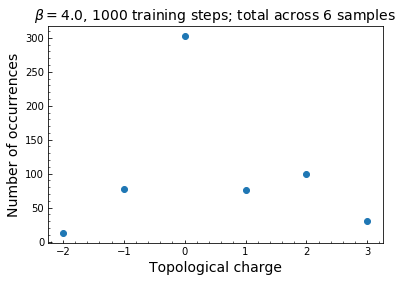

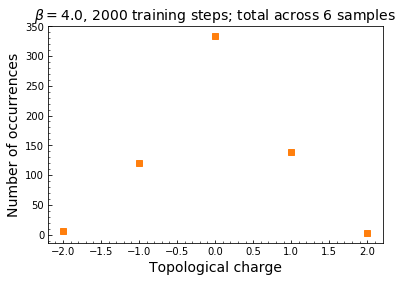

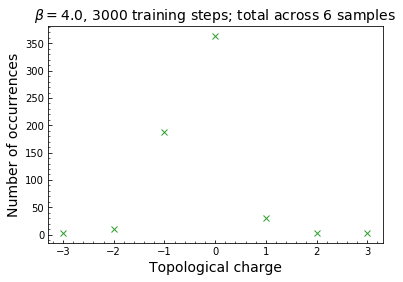

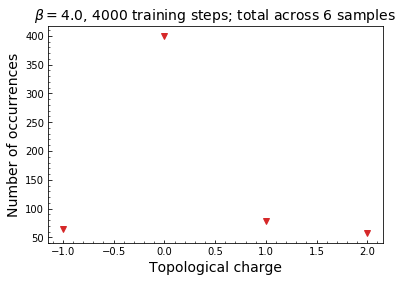

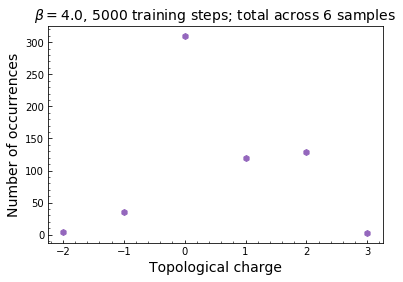

In [169]:
train_charges_dict = train_observables_dicts[2]
params, _, _, _, figs_dir_dict = find_samples(log_dir, training=True)
title_str_key = 'training'
count_dict = {}
idx = 0
for key, val in train_charges_dict.items():
    step, beta = key
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='')
                #fillstyle='none')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} {title_str_key} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=14)
    out_dir = os.path.join(
        figs_dir_dict[key], 'topological_charges_counts'
    )
    check_else_make_dir(out_dir)
    out_file = os.path.join(
        out_dir,
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [112]:
plt.close('all')

### Calculate observables for samples generated **_after_** training.
 - Again, samples are generated at $\beta = \beta_{\mathrm{final}}$.
 - In contrast to the samples generated **_during_** training (which are all ran for $\sim 100$ steps), we now look at generating longer chains (i.e. longer runs).

In [152]:
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'HMC', 'run_L8_181')
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=None, 
                                     training=False,
                                     frac=None)

Calculating observables for 20000...
step: 0 / 20000 beta:  4  time/step: 0.002538 avg action: 52.59  exact plaquette: 0.8635 avg plaquette: 0.1782 


top_charges: [ 0. -1.  0.  0.  0. -3.]


step: 10 / 20000 beta:  4  time/step: 0.002432 avg action: 35.13  exact plaquette: 0.8635 avg plaquette: 0.4511 


top_charges: [ 0. -1.  0. -2.  1.  0.]


step: 20 / 20000 beta:  4  time/step: 0.00178 avg action: 23.34  exact plaquette: 0.8635 avg plaquette: 0.6353 


top_charges: [-1. -3. -2. -3.  0.  0.]


step: 30 / 20000 beta:  4  time/step: 0.002803 avg action: 16.73  exact plaquette: 0.8635 avg plaquette: 0.7385 


top_charges: [-3. -2. -2. -3.  0. -1.]


step: 40 / 20000 beta:  4  time/step: 0.001932 avg action: 13.94  exact plaquette: 0.8635 avg plaquette: 0.7822 


top_charges: [-2. -3. -2. -3.  0.  0.]


step: 50 / 20000 beta:  4  time/step: 0.002122 avg action: 12.03  exact plaquette: 0.8635 avg plaquette: 0.812  


top_charges: [-1. -1. -2. -3.  0. -1.]


step: 60 / 20000 beta:  4  ti

step: 530 / 20000 beta:  4  time/step: 0.004666 avg action: 9.459  exact plaquette: 0.8635 avg plaquette: 0.8522 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 540 / 20000 beta:  4  time/step: 0.003735 avg action: 8.856  exact plaquette: 0.8635 avg plaquette: 0.8616 


top_charges: [ 0. -1. -1. -2.  0. -1.]


step: 550 / 20000 beta:  4  time/step: 0.001859 avg action: 8.563  exact plaquette: 0.8635 avg plaquette: 0.8662 


top_charges: [-1.  0. -2. -2.  0.  0.]


step: 560 / 20000 beta:  4  time/step: 0.002424 avg action: 7.529  exact plaquette: 0.8635 avg plaquette: 0.8824 


top_charges: [ 0. -1. -2. -1.  0. -1.]


step: 570 / 20000 beta:  4  time/step: 0.002443 avg action: 8.951  exact plaquette: 0.8635 avg plaquette: 0.8601 


top_charges: [-1.  0. -1. -1.  0.  0.]


step: 580 / 20000 beta:  4  time/step: 0.002359 avg action: 10.38  exact plaquette: 0.8635 avg plaquette: 0.8378 


top_charges: [ 0. -1. -1. -2.  0. -1.]


step: 590 / 20000 beta:  4  time/step: 0.001664 avg action

step: 1140 / 20000 beta:  4  time/step: 0.002349 avg action: 8.677  exact plaquette: 0.8635 avg plaquette: 0.8644 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 1150 / 20000 beta:  4  time/step: 0.002386 avg action: 9.107  exact plaquette: 0.8635 avg plaquette: 0.8577 


top_charges: [ 0.  0.  0. -2.  0.  0.]


step: 1160 / 20000 beta:  4  time/step: 0.001837 avg action: 10.47  exact plaquette: 0.8635 avg plaquette: 0.8364 


top_charges: [ 0.  0.  0. -2.  0. -1.]


step: 1170 / 20000 beta:  4  time/step: 0.002196 avg action: 9.465  exact plaquette: 0.8635 avg plaquette: 0.8521 


top_charges: [ 0.  0.  0. -2.  0.  0.]


step: 1180 / 20000 beta:  4  time/step: 0.001985 avg action: 8.809  exact plaquette: 0.8635 avg plaquette: 0.8624 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 1190 / 20000 beta:  4  time/step: 0.002439 avg action: 9.173  exact plaquette: 0.8635 avg plaquette: 0.8567 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 1200 / 20000 beta:  4  time/step: 0.001816 avg

step: 1720 / 20000 beta:  4  time/step: 0.001845 avg action: 9.647  exact plaquette: 0.8635 avg plaquette: 0.8493 


top_charges: [ 0.  1.  1. -1.  0. -1.]


step: 1730 / 20000 beta:  4  time/step: 0.002657 avg action: 9.839  exact plaquette: 0.8635 avg plaquette: 0.8463 


top_charges: [ 0.  1.  1. -2.  0.  0.]


step: 1740 / 20000 beta:  4  time/step: 0.001862 avg action: 8.731  exact plaquette: 0.8635 avg plaquette: 0.8636 


top_charges: [-1.  1.  1. -2.  0. -1.]


step: 1750 / 20000 beta:  4  time/step: 0.002379 avg action: 8.709  exact plaquette: 0.8635 avg plaquette: 0.8639 


top_charges: [ 0.  1.  0. -2.  0. -1.]


step: 1760 / 20000 beta:  4  time/step: 0.001932 avg action: 9.079  exact plaquette: 0.8635 avg plaquette: 0.8581 


top_charges: [-1.  1.  0. -2.  0. -1.]


step: 1770 / 20000 beta:  4  time/step: 0.001713 avg action: 8.724  exact plaquette: 0.8635 avg plaquette: 0.8637 


top_charges: [-1.  0.  1. -1.  0. -1.]


step: 1780 / 20000 beta:  4  time/step: 0.001614 avg

step: 2240 / 20000 beta:  4  time/step: 0.002765 avg action: 9.212  exact plaquette: 0.8635 avg plaquette: 0.8561 


top_charges: [ 0.  1.  1. -1.  0.  0.]


step: 2250 / 20000 beta:  4  time/step: 0.003234 avg action: 9.809  exact plaquette: 0.8635 avg plaquette: 0.8467 


top_charges: [-1.  0.  1. -1.  0. -1.]


step: 2260 / 20000 beta:  4  time/step: 0.002073 avg action: 9.746  exact plaquette: 0.8635 avg plaquette: 0.8477 


top_charges: [-1.  1.  0. -2.  0.  0.]


step: 2270 / 20000 beta:  4  time/step: 0.001651 avg action: 10.72  exact plaquette: 0.8635 avg plaquette: 0.8325 


top_charges: [-1.  1.  1. -1.  0. -1.]


step: 2280 / 20000 beta:  4  time/step: 0.001854 avg action:  8.89  exact plaquette: 0.8635 avg plaquette: 0.8611 


top_charges: [-1.  1.  0. -1.  0. -1.]


step: 2290 / 20000 beta:  4  time/step: 0.001737 avg action: 9.668  exact plaquette: 0.8635 avg plaquette: 0.8489 


top_charges: [-1.  1.  0. -2.  0. -1.]


step: 2300 / 20000 beta:  4  time/step: 0.00188 avg 

step: 2850 / 20000 beta:  4  time/step: 0.001697 avg action:  8.34  exact plaquette: 0.8635 avg plaquette: 0.8697 


top_charges: [-1.  0.  0. -1.  0.  0.]


step: 2860 / 20000 beta:  4  time/step: 0.002251 avg action: 7.507  exact plaquette: 0.8635 avg plaquette: 0.8827 


top_charges: [ 0.  1.  1. -2.  0. -1.]


step: 2870 / 20000 beta:  4  time/step: 0.003051 avg action: 9.376  exact plaquette: 0.8635 avg plaquette: 0.8535 


top_charges: [ 0.  0.  1. -2.  0. -1.]


step: 2880 / 20000 beta:  4  time/step: 0.002636 avg action: 9.295  exact plaquette: 0.8635 avg plaquette: 0.8548 


top_charges: [ 0.  0.  0. -1.  0. -1.]


step: 2890 / 20000 beta:  4  time/step: 0.004193 avg action:  9.46  exact plaquette: 0.8635 avg plaquette: 0.8522 


top_charges: [-1.  0.  1. -1.  0.  0.]


step: 2900 / 20000 beta:  4  time/step: 0.003238 avg action: 9.757  exact plaquette: 0.8635 avg plaquette: 0.8475 


top_charges: [-1.  0.  0. -2.  0.  0.]


step: 2910 / 20000 beta:  4  time/step: 0.006221 avg

step: 3390 / 20000 beta:  4  time/step: 0.002021 avg action: 9.414  exact plaquette: 0.8635 avg plaquette: 0.8529 


top_charges: [ 0.  1.  1. -1.  0.  0.]


step: 3400 / 20000 beta:  4  time/step: 0.004072 avg action: 9.109  exact plaquette: 0.8635 avg plaquette: 0.8577 


top_charges: [ 0.  1.  0. -2.  0.  0.]


step: 3410 / 20000 beta:  4  time/step: 0.00206 avg action: 8.503  exact plaquette: 0.8635 avg plaquette: 0.8671 


top_charges: [-1.  1.  1. -1.  0. -1.]


step: 3420 / 20000 beta:  4  time/step: 0.002043 avg action: 8.436  exact plaquette: 0.8635 avg plaquette: 0.8682 


top_charges: [-1.  0.  1. -2.  0. -1.]


step: 3430 / 20000 beta:  4  time/step: 0.001675 avg action: 7.936  exact plaquette: 0.8635 avg plaquette: 0.876  


top_charges: [-1.  1.  1. -2.  0.  0.]


step: 3440 / 20000 beta:  4  time/step: 0.001908 avg action:  8.19  exact plaquette: 0.8635 avg plaquette: 0.872  


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 3450 / 20000 beta:  4  time/step: 0.001994 avg 

step: 3960 / 20000 beta:  4  time/step: 0.004037 avg action: 9.242  exact plaquette: 0.8635 avg plaquette: 0.8556 


top_charges: [ 0.  1.  1. -1.  0. -1.]


step: 3970 / 20000 beta:  4  time/step: 0.002771 avg action: 9.017  exact plaquette: 0.8635 avg plaquette: 0.8591 


top_charges: [-1.  1.  0. -1.  0.  0.]


step: 3980 / 20000 beta:  4  time/step: 0.001712 avg action: 8.401  exact plaquette: 0.8635 avg plaquette: 0.8687 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 3990 / 20000 beta:  4  time/step: 0.00194 avg action: 8.502  exact plaquette: 0.8635 avg plaquette: 0.8672 


top_charges: [ 0.  1.  1. -2.  0.  0.]


step: 4000 / 20000 beta:  4  time/step: 0.002649 avg action: 8.848  exact plaquette: 0.8635 avg plaquette: 0.8618 


top_charges: [ 0.  0.  1. -2.  0.  0.]


step: 4010 / 20000 beta:  4  time/step: 0.001607 avg action: 9.105  exact plaquette: 0.8635 avg plaquette: 0.8577 


top_charges: [ 0.  0.  1. -2.  0.  0.]


step: 4020 / 20000 beta:  4  time/step: 0.001576 avg 

step: 4540 / 20000 beta:  4  time/step: 0.001851 avg action: 9.251  exact plaquette: 0.8635 avg plaquette: 0.8555 


top_charges: [ 0.  1.  0. -2.  0.  0.]


step: 4550 / 20000 beta:  4  time/step: 0.002965 avg action:  9.09  exact plaquette: 0.8635 avg plaquette: 0.858  


top_charges: [ 0.  1.  1. -2.  0.  0.]


step: 4560 / 20000 beta:  4  time/step: 0.002963 avg action: 8.308  exact plaquette: 0.8635 avg plaquette: 0.8702 


top_charges: [ 0.  1.  0. -1.  0.  0.]


step: 4570 / 20000 beta:  4  time/step: 0.001792 avg action: 9.548  exact plaquette: 0.8635 avg plaquette: 0.8508 


top_charges: [-1.  1.  1. -1.  0. -1.]


step: 4580 / 20000 beta:  4  time/step: 0.001629 avg action: 9.111  exact plaquette: 0.8635 avg plaquette: 0.8576 


top_charges: [-1.  1.  1. -2.  0. -1.]


step: 4590 / 20000 beta:  4  time/step: 0.002126 avg action: 9.243  exact plaquette: 0.8635 avg plaquette: 0.8556 


top_charges: [-1.  0.  1. -1.  0. -1.]


step: 4600 / 20000 beta:  4  time/step: 0.001681 avg

step: 5090 / 20000 beta:  4  time/step: 0.00303 avg action: 10.21  exact plaquette: 0.8635 avg plaquette: 0.8405 


top_charges: [ 0.  1.  0. -2.  2.  0.]


step: 5100 / 20000 beta:  4  time/step: 0.002241 avg action: 8.456  exact plaquette: 0.8635 avg plaquette: 0.8679 


top_charges: [-1.  1.  1.  0.  2. -1.]


step: 5110 / 20000 beta:  4  time/step: 0.003396 avg action: 8.288  exact plaquette: 0.8635 avg plaquette: 0.8705 


top_charges: [-1.  1.  1. -2.  2.  0.]


step: 5120 / 20000 beta:  4  time/step: 0.002967 avg action: 9.469  exact plaquette: 0.8635 avg plaquette: 0.852  


top_charges: [-1.  1.  0.  0.  2. -1.]


step: 5130 / 20000 beta:  4  time/step: 0.00324 avg action: 10.05  exact plaquette: 0.8635 avg plaquette: 0.8429 


top_charges: [-1.  0.  1. -1.  1.  0.]


step: 5140 / 20000 beta:  4  time/step: 0.00188 avg action: 8.858  exact plaquette: 0.8635 avg plaquette: 0.8616 


top_charges: [-1.  0.  1. -1.  2. -1.]


step: 5150 / 20000 beta:  4  time/step: 0.001697 avg ac

step: 5650 / 20000 beta:  4  time/step: 0.003173 avg action: 9.374  exact plaquette: 0.8635 avg plaquette: 0.8535 


top_charges: [ 0.  0.  0. -1.  2.  0.]


step: 5660 / 20000 beta:  4  time/step: 0.002346 avg action: 8.659  exact plaquette: 0.8635 avg plaquette: 0.8647 


top_charges: [ 0.  0.  0. -1.  2. -1.]


step: 5670 / 20000 beta:  4  time/step: 0.002739 avg action: 9.258  exact plaquette: 0.8635 avg plaquette: 0.8553 


top_charges: [ 0.  1.  1.  0.  2. -1.]


step: 5680 / 20000 beta:  4  time/step: 0.001902 avg action: 10.05  exact plaquette: 0.8635 avg plaquette: 0.843  


top_charges: [0. 1. 0. 0. 2. 0.]


step: 5690 / 20000 beta:  4  time/step: 0.001693 avg action:  8.91  exact plaquette: 0.8635 avg plaquette: 0.8608 


top_charges: [ 0.  1.  1. -1.  1. -1.]


step: 5700 / 20000 beta:  4  time/step: 0.002957 avg action: 8.923  exact plaquette: 0.8635 avg plaquette: 0.8606 


top_charges: [ 0.  1.  0. -1.  2. -1.]


step: 5710 / 20000 beta:  4  time/step: 0.002182 avg actio

step: 6260 / 20000 beta:  4  time/step: 0.001624 avg action: 8.163  exact plaquette: 0.8635 avg plaquette: 0.8725 


top_charges: [0. 0. 0. 0. 2. 0.]


step: 6270 / 20000 beta:  4  time/step: 0.002179 avg action: 8.756  exact plaquette: 0.8635 avg plaquette: 0.8632 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 6280 / 20000 beta:  4  time/step: 0.002384 avg action: 9.194  exact plaquette: 0.8635 avg plaquette: 0.8563 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 6290 / 20000 beta:  4  time/step: 0.002128 avg action: 7.723  exact plaquette: 0.8635 avg plaquette: 0.8793 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 6300 / 20000 beta:  4  time/step: 0.003883 avg action: 7.996  exact plaquette: 0.8635 avg plaquette: 0.8751 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 6310 / 20000 beta:  4  time/step: 0.003151 avg action: 7.403  exact plaquette: 0.8635 avg plaquette: 0.8843 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 6320 / 20000 beta:  4  time/step: 0.003382 avg action:  7.72  exact plaquette: 0.8

step: 6830 / 20000 beta:  4  time/step: 0.001796 avg action: 8.468  exact plaquette: 0.8635 avg plaquette: 0.8677 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 6840 / 20000 beta:  4  time/step: 0.002128 avg action: 8.036  exact plaquette: 0.8635 avg plaquette: 0.8744 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 6850 / 20000 beta:  4  time/step: 0.001728 avg action: 8.706  exact plaquette: 0.8635 avg plaquette: 0.864  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 6860 / 20000 beta:  4  time/step: 0.001938 avg action: 7.887  exact plaquette: 0.8635 avg plaquette: 0.8768 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 6870 / 20000 beta:  4  time/step: 0.00199 avg action: 8.968  exact plaquette: 0.8635 avg plaquette: 0.8599 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 6880 / 20000 beta:  4  time/step: 0.001708 avg action: 8.898  exact plaquette: 0.8635 avg plaquette: 0.861  


top_charges: [0. 0. 1. 0. 0. 0.]


step: 6890 / 20000 beta:  4  time/step: 0.002155 avg action: 8.234  exact plaquette: 0.86

step: 7390 / 20000 beta:  4  time/step: 0.002042 avg action: 8.003  exact plaquette: 0.8635 avg plaquette: 0.875  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7400 / 20000 beta:  4  time/step: 0.001707 avg action: 8.377  exact plaquette: 0.8635 avg plaquette: 0.8691 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7410 / 20000 beta:  4  time/step: 0.00168 avg action: 9.052  exact plaquette: 0.8635 avg plaquette: 0.8586 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7420 / 20000 beta:  4  time/step: 0.002209 avg action:  9.18  exact plaquette: 0.8635 avg plaquette: 0.8566 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7430 / 20000 beta:  4  time/step: 0.001876 avg action: 9.196  exact plaquette: 0.8635 avg plaquette: 0.8563 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7440 / 20000 beta:  4  time/step: 0.001978 avg action: 9.142  exact plaquette: 0.8635 avg plaquette: 0.8572 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 7450 / 20000 beta:  4  time/step: 0.002126 avg action: 9.894  exact plaquette: 0.86

step: 7990 / 20000 beta:  4  time/step: 0.001829 avg action:  8.09  exact plaquette: 0.8635 avg plaquette: 0.8736 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8000 / 20000 beta:  4  time/step: 0.001745 avg action: 8.068  exact plaquette: 0.8635 avg plaquette: 0.8739 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8010 / 20000 beta:  4  time/step: 0.001725 avg action: 7.902  exact plaquette: 0.8635 avg plaquette: 0.8765 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8020 / 20000 beta:  4  time/step: 0.001871 avg action: 8.452  exact plaquette: 0.8635 avg plaquette: 0.8679 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8030 / 20000 beta:  4  time/step: 0.001931 avg action: 8.087  exact plaquette: 0.8635 avg plaquette: 0.8736 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8040 / 20000 beta:  4  time/step: 0.002801 avg action: 9.355  exact plaquette: 0.8635 avg plaquette: 0.8538 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8050 / 20000 beta:  4  time/step: 0.002531 avg action: 8.478  exact plaquette: 0.8

step: 8620 / 20000 beta:  4  time/step: 0.002383 avg action: 9.279  exact plaquette: 0.8635 avg plaquette: 0.855  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8630 / 20000 beta:  4  time/step: 0.001805 avg action: 8.187  exact plaquette: 0.8635 avg plaquette: 0.8721 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8640 / 20000 beta:  4  time/step: 0.001813 avg action: 8.692  exact plaquette: 0.8635 avg plaquette: 0.8642 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8650 / 20000 beta:  4  time/step: 0.002035 avg action: 8.531  exact plaquette: 0.8635 avg plaquette: 0.8667 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8660 / 20000 beta:  4  time/step: 0.001627 avg action: 8.558  exact plaquette: 0.8635 avg plaquette: 0.8663 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 8670 / 20000 beta:  4  time/step: 0.001818 avg action: 7.967  exact plaquette: 0.8635 avg plaquette: 0.8755 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 8680 / 20000 beta:  4  time/step: 0.001612 avg action: 9.111  exact plaquette: 0.8

step: 9160 / 20000 beta:  4  time/step: 0.00667 avg action:  8.87  exact plaquette: 0.8635 avg plaquette: 0.8614 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9170 / 20000 beta:  4  time/step: 0.005429 avg action:  8.63  exact plaquette: 0.8635 avg plaquette: 0.8652 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9180 / 20000 beta:  4  time/step: 0.003817 avg action: 8.076  exact plaquette: 0.8635 avg plaquette: 0.8738 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9190 / 20000 beta:  4  time/step: 0.005468 avg action: 8.137  exact plaquette: 0.8635 avg plaquette: 0.8729 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9200 / 20000 beta:  4  time/step: 0.004805 avg action:  8.32  exact plaquette: 0.8635 avg plaquette:  0.87  


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9210 / 20000 beta:  4  time/step: 0.004077 avg action: 8.967  exact plaquette: 0.8635 avg plaquette: 0.8599 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9220 / 20000 beta:  4  time/step: 0.005922 avg action: 8.444  exact plaquette: 0.86

step: 9750 / 20000 beta:  4  time/step: 0.002726 avg action: 8.959  exact plaquette: 0.8635 avg plaquette:  0.86  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 9760 / 20000 beta:  4  time/step: 0.003061 avg action: 8.772  exact plaquette: 0.8635 avg plaquette: 0.8629 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 9770 / 20000 beta:  4  time/step: 0.002652 avg action: 9.332  exact plaquette: 0.8635 avg plaquette: 0.8542 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9780 / 20000 beta:  4  time/step: 0.003383 avg action: 7.818  exact plaquette: 0.8635 avg plaquette: 0.8778 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9790 / 20000 beta:  4  time/step: 0.003401 avg action: 8.221  exact plaquette: 0.8635 avg plaquette: 0.8715 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9800 / 20000 beta:  4  time/step: 0.003483 avg action: 8.436  exact plaquette: 0.8635 avg plaquette: 0.8682 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 9810 / 20000 beta:  4  time/step: 0.00234 avg action: 9.044  exact plaquette: 0.86

step: 10350 / 20000 beta:  4  time/step: 0.002367 avg action: 8.304  exact plaquette: 0.8635 avg plaquette: 0.8702 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 10360 / 20000 beta:  4  time/step: 0.002218 avg action: 7.846  exact plaquette: 0.8635 avg plaquette: 0.8774 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 10370 / 20000 beta:  4  time/step: 0.002211 avg action: 8.373  exact plaquette: 0.8635 avg plaquette: 0.8692 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 10380 / 20000 beta:  4  time/step: 0.002127 avg action: 8.819  exact plaquette: 0.8635 avg plaquette: 0.8622 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 10390 / 20000 beta:  4  time/step: 0.001988 avg action: 7.989  exact plaquette: 0.8635 avg plaquette: 0.8752 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 10400 / 20000 beta:  4  time/step: 0.001681 avg action: 8.664  exact plaquette: 0.8635 avg plaquette: 0.8646 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 10410 / 20000 beta:  4  time/step: 0.001874 avg action: 9.662  exact plaquet

step: 10910 / 20000 beta:  4  time/step: 0.005867 avg action: 8.357  exact plaquette: 0.8635 avg plaquette: 0.8694 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 10920 / 20000 beta:  4  time/step: 0.002894 avg action: 9.411  exact plaquette: 0.8635 avg plaquette: 0.853  


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 10930 / 20000 beta:  4  time/step: 0.002334 avg action: 8.775  exact plaquette: 0.8635 avg plaquette: 0.8629 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 10940 / 20000 beta:  4  time/step: 0.001608 avg action: 9.349  exact plaquette: 0.8635 avg plaquette: 0.8539 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 10950 / 20000 beta:  4  time/step: 0.00313 avg action: 9.905  exact plaquette: 0.8635 avg plaquette: 0.8452 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 10960 / 20000 beta:  4  time/step: 0.002741 avg action: 9.235  exact plaquette: 0.8635 avg plaquette: 0.8557 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 10970 / 20000 beta:  4  time/step: 0.003326 avg

step: 11450 / 20000 beta:  4  time/step: 0.003198 avg action:  10.3  exact plaquette: 0.8635 avg plaquette: 0.8391 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 11460 / 20000 beta:  4  time/step: 0.002878 avg action: 9.867  exact plaquette: 0.8635 avg plaquette: 0.8458 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 11470 / 20000 beta:  4  time/step: 0.001746 avg action:  10.5  exact plaquette: 0.8635 avg plaquette: 0.8359 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 11480 / 20000 beta:  4  time/step: 0.001685 avg action: 10.15  exact plaquette: 0.8635 avg plaquette: 0.8413 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 11490 / 20000 beta:  4  time/step: 0.001729 avg action:  9.2   exact plaquette: 0.8635 avg plaquette: 0.8563 


top_charges: [ 1. -1.  0.  0.  0.  0.]


step: 11500 / 20000 beta:  4  time/step: 0.001904 avg action: 9.554  exact plaquette: 0.8635 avg plaquette: 0.8507 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 11510 / 20000 beta:  4  time/step: 0.001874 avg action: 8.

step: 12010 / 20000 beta:  4  time/step: 0.002756 avg action: 8.761  exact plaquette: 0.8635 avg plaquette: 0.8631 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 12020 / 20000 beta:  4  time/step: 0.002208 avg action: 8.211  exact plaquette: 0.8635 avg plaquette: 0.8717 


top_charges: [ 0. -1.  1.  0.  0.  0.]


step: 12030 / 20000 beta:  4  time/step: 0.001926 avg action: 8.743  exact plaquette: 0.8635 avg plaquette: 0.8634 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 12040 / 20000 beta:  4  time/step: 0.001661 avg action:  8.21  exact plaquette: 0.8635 avg plaquette: 0.8717 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 12050 / 20000 beta:  4  time/step: 0.001593 avg action: 9.262  exact plaquette: 0.8635 avg plaquette: 0.8553 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 12060 / 20000 beta:  4  time/step: 0.001978 avg action: 8.689  exact plaquette: 0.8635 avg plaquette: 0.8642 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 12070 / 20000 beta:  4  time/step: 0.002169 avg action: 8.376  exact p

step: 12620 / 20000 beta:  4  time/step: 0.00163 avg action: 7.767  exact plaquette: 0.8635 avg plaquette: 0.8786 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 12630 / 20000 beta:  4  time/step: 0.002058 avg action: 7.473  exact plaquette: 0.8635 avg plaquette: 0.8832 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 12640 / 20000 beta:  4  time/step: 0.001702 avg action: 7.674  exact plaquette: 0.8635 avg plaquette: 0.8801 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 12650 / 20000 beta:  4  time/step: 0.001998 avg action: 9.158  exact plaquette: 0.8635 avg plaquette: 0.8569 


top_charges: [0. 0. 1. 0. 1. 0.]


step: 12660 / 20000 beta:  4  time/step: 0.002213 avg action: 8.562  exact plaquette: 0.8635 avg plaquette: 0.8662 


top_charges: [0. 0. 1. 0. 0. 0.]


step: 12670 / 20000 beta:  4  time/step: 0.001748 avg action: 9.604  exact plaquette: 0.8635 avg plaquette: 0.8499 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 12680 / 20000 beta:  4  time/step: 0.00183 avg action: 8.816  exact plaquette

step: 13180 / 20000 beta:  4  time/step: 0.002351 avg action: 10.01  exact plaquette: 0.8635 avg plaquette: 0.8436 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 13190 / 20000 beta:  4  time/step: 0.001731 avg action: 8.857  exact plaquette: 0.8635 avg plaquette: 0.8616 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 13200 / 20000 beta:  4  time/step: 0.002177 avg action:  9.53  exact plaquette: 0.8635 avg plaquette: 0.8511 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 13210 / 20000 beta:  4  time/step: 0.00221 avg action: 8.686  exact plaquette: 0.8635 avg plaquette: 0.8643 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 13220 / 20000 beta:  4  time/step: 0.003048 avg action: 7.997  exact plaquette: 0.8635 avg plaquette: 0.8751 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 13230 / 20000 beta:  4  time/step: 0.001805 avg action: 8.439  exact plaquette: 0.8635 avg plaquette: 0.8681 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 13240 / 20000 beta:  4  time/step: 0.002653 avg action: 7.9

step: 13770 / 20000 beta:  4  time/step: 0.001783 avg action: 7.933  exact plaquette: 0.8635 avg plaquette: 0.8761 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 13780 / 20000 beta:  4  time/step: 0.002317 avg action: 7.895  exact plaquette: 0.8635 avg plaquette: 0.8766 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 13790 / 20000 beta:  4  time/step: 0.001593 avg action: 8.604  exact plaquette: 0.8635 avg plaquette: 0.8656 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 13800 / 20000 beta:  4  time/step: 0.001894 avg action: 8.135  exact plaquette: 0.8635 avg plaquette: 0.8729 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 13810 / 20000 beta:  4  time/step: 0.001807 avg action: 8.593  exact plaquette: 0.8635 avg plaquette: 0.8657 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 13820 / 20000 beta:  4  time/step: 0.001876 avg action: 8.287  exact plaquette: 0.8635 avg plaquette: 0.8705 


top_charges: [0. 0. 0. 0. 1. 0.]


step: 13830 / 20000 beta:  4  time/step: 0.001919 avg action: 8.572  exact plaquet

step: 14390 / 20000 beta:  4  time/step: 0.002251 avg action: 9.269  exact plaquette: 0.8635 avg plaquette: 0.8552 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 14400 / 20000 beta:  4  time/step: 0.002201 avg action: 7.301  exact plaquette: 0.8635 avg plaquette: 0.8859 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 14410 / 20000 beta:  4  time/step: 0.001819 avg action: 9.265  exact plaquette: 0.8635 avg plaquette: 0.8552 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 14420 / 20000 beta:  4  time/step: 0.002417 avg action:  8.5   exact plaquette: 0.8635 avg plaquette: 0.8672 


top_charges: [0. 0. 0. 1. 0. 0.]


step: 14430 / 20000 beta:  4  time/step: 0.001863 avg action: 10.14  exact plaquette: 0.8635 avg plaquette: 0.8416 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 14440 / 20000 beta:  4  time/step: 0.001733 avg action: 8.674  exact plaquette: 0.8635 avg plaquette: 0.8645 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 14450 / 20000 beta:  4  time/step: 0.001622 avg action: 8.823  exact plaquet

step: 15030 / 20000 beta:  4  time/step: 0.002055 avg action: 8.835  exact plaquette: 0.8635 avg plaquette: 0.8619 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 15040 / 20000 beta:  4  time/step: 0.001629 avg action:  9.3   exact plaquette: 0.8635 avg plaquette: 0.8547 


top_charges: [0. 0. 0. 0. 1. 2.]


step: 15050 / 20000 beta:  4  time/step: 0.001625 avg action: 9.219  exact plaquette: 0.8635 avg plaquette: 0.8559 


top_charges: [0. 0. 0. 0. 0. 2.]


step: 15060 / 20000 beta:  4  time/step: 0.001891 avg action: 10.38  exact plaquette: 0.8635 avg plaquette: 0.8378 


top_charges: [0. 0. 0. 1. 0. 1.]


step: 15070 / 20000 beta:  4  time/step: 0.002091 avg action: 10.27  exact plaquette: 0.8635 avg plaquette: 0.8395 


top_charges: [0. 0. 0. 0. 1. 2.]


step: 15080 / 20000 beta:  4  time/step: 0.001803 avg action: 8.806  exact plaquette: 0.8635 avg plaquette: 0.8624 


top_charges: [0. 0. 0. 0. 0. 2.]


step: 15090 / 20000 beta:  4  time/step: 0.002071 avg action: 9.085  exact plaquet

step: 15660 / 20000 beta:  4  time/step: 0.001742 avg action: 9.152  exact plaquette: 0.8635 avg plaquette: 0.857  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 15670 / 20000 beta:  4  time/step: 0.001822 avg action: 9.512  exact plaquette: 0.8635 avg plaquette: 0.8514 


top_charges: [0. 0. 0. 1. 0. 1.]


step: 15680 / 20000 beta:  4  time/step: 0.001773 avg action: 9.834  exact plaquette: 0.8635 avg plaquette: 0.8463 


top_charges: [0. 0. 0. 1. 1. 1.]


step: 15690 / 20000 beta:  4  time/step: 0.001693 avg action: 8.969  exact plaquette: 0.8635 avg plaquette: 0.8599 


top_charges: [0. 0. 0. 1. 1. 1.]


step: 15700 / 20000 beta:  4  time/step: 0.001693 avg action: 9.423  exact plaquette: 0.8635 avg plaquette: 0.8528 


top_charges: [0. 0. 0. 0. 1. 1.]


step: 15710 / 20000 beta:  4  time/step: 0.001762 avg action: 8.658  exact plaquette: 0.8635 avg plaquette: 0.8647 


top_charges: [0. 0. 0. 1. 1. 1.]


step: 15720 / 20000 beta:  4  time/step: 0.001727 avg action: 9.835  exact plaquet

step: 16290 / 20000 beta:  4  time/step: 0.002052 avg action: 8.553  exact plaquette: 0.8635 avg plaquette: 0.8664 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 16300 / 20000 beta:  4  time/step: 0.002101 avg action: 8.904  exact plaquette: 0.8635 avg plaquette: 0.8609 


top_charges: [ 0. -1.  0.  1.  0.  1.]


step: 16310 / 20000 beta:  4  time/step: 0.001959 avg action: 8.461  exact plaquette: 0.8635 avg plaquette: 0.8678 


top_charges: [0. 0. 0. 1. 0. 1.]


step: 16320 / 20000 beta:  4  time/step: 0.002004 avg action: 9.417  exact plaquette: 0.8635 avg plaquette: 0.8529 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 16330 / 20000 beta:  4  time/step: 0.001601 avg action:  9.5   exact plaquette: 0.8635 avg plaquette: 0.8516 


top_charges: [0. 0. 0. 1. 1. 0.]


step: 16340 / 20000 beta:  4  time/step: 0.002331 avg action: 9.637  exact plaquette: 0.8635 avg plaquette: 0.8494 


top_charges: [0. 0. 0. 0. 1. 1.]


step: 16350 / 20000 beta:  4  time/step: 0.002275 avg action: 9.131  exact p

step: 16830 / 20000 beta:  4  time/step: 0.002118 avg action: 8.613  exact plaquette: 0.8635 avg plaquette: 0.8654 


top_charges: [ 0. -1.  0.  1.  1.  1.]


step: 16840 / 20000 beta:  4  time/step: 0.001714 avg action: 8.514  exact plaquette: 0.8635 avg plaquette: 0.867  


top_charges: [0. 0. 0. 0. 0. 0.]


step: 16850 / 20000 beta:  4  time/step: 0.00263 avg action:  7.91  exact plaquette: 0.8635 avg plaquette: 0.8764 


top_charges: [ 0. -1.  0.  1.  1.  0.]


step: 16860 / 20000 beta:  4  time/step: 0.00312 avg action: 8.993  exact plaquette: 0.8635 avg plaquette: 0.8595 


top_charges: [0. 0. 0. 1. 1. 1.]


step: 16870 / 20000 beta:  4  time/step: 0.002131 avg action:  9.37  exact plaquette: 0.8635 avg plaquette: 0.8536 


top_charges: [0. 0. 0. 1. 0. 1.]


step: 16880 / 20000 beta:  4  time/step: 0.001648 avg action: 8.184  exact plaquette: 0.8635 avg plaquette: 0.8721 


top_charges: [0. 0. 0. 1. 1. 1.]


step: 16890 / 20000 beta:  4  time/step: 0.002836 avg action: 8.673  exa

step: 17440 / 20000 beta:  4  time/step: 0.001686 avg action: 8.116  exact plaquette: 0.8635 avg plaquette: 0.8732 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 17450 / 20000 beta:  4  time/step: 0.00174 avg action: 7.883  exact plaquette: 0.8635 avg plaquette: 0.8768 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 17460 / 20000 beta:  4  time/step: 0.002113 avg action: 8.746  exact plaquette: 0.8635 avg plaquette: 0.8633 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 17470 / 20000 beta:  4  time/step: 0.001794 avg action: 8.617  exact plaquette: 0.8635 avg plaquette: 0.8654 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 17480 / 20000 beta:  4  time/step: 0.001931 avg action:  8.53  exact plaquette: 0.8635 avg plaquette: 0.8667 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 17490 / 20000 beta:  4  time/step: 0.001794 avg action: 8.736  exact plaquette: 0.8635 avg plaquette: 0.8635 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 17500 / 20000 beta:  4  time/step: 0.001596 avg action: 9.1

step: 17970 / 20000 beta:  4  time/step: 0.002488 avg action: 8.572  exact plaquette: 0.8635 avg plaquette: 0.8661 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 17980 / 20000 beta:  4  time/step: 0.002005 avg action: 8.599  exact plaquette: 0.8635 avg plaquette: 0.8656 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 17990 / 20000 beta:  4  time/step: 0.001762 avg action: 8.924  exact plaquette: 0.8635 avg plaquette: 0.8606 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 18000 / 20000 beta:  4  time/step: 0.00173 avg action: 7.946  exact plaquette: 0.8635 avg plaquette: 0.8758 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 18010 / 20000 beta:  4  time/step: 0.001789 avg action: 8.374  exact plaquette: 0.8635 avg plaquette: 0.8692 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 18020 / 20000 beta:  4  time/step: 0.002032 avg action: 7.928  exact plaquette: 0.8635 avg plaquette: 0.8761 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 18030 / 20000 beta:  4  time/step: 0.001659 avg actio

step: 18580 / 20000 beta:  4  time/step: 0.001726 avg action: 7.761  exact plaquette: 0.8635 avg plaquette: 0.8787 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 18590 / 20000 beta:  4  time/step: 0.001626 avg action: 8.507  exact plaquette: 0.8635 avg plaquette: 0.8671 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 18600 / 20000 beta:  4  time/step: 0.001915 avg action: 8.548  exact plaquette: 0.8635 avg plaquette: 0.8664 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 18610 / 20000 beta:  4  time/step: 0.002003 avg action:  8.8   exact plaquette: 0.8635 avg plaquette: 0.8625 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 18620 / 20000 beta:  4  time/step: 0.002  avg action: 8.691  exact plaquette: 0.8635 avg plaquette: 0.8642 


top_charges: [0. 0. 0. 0. 0. 0.]


step: 18630 / 20000 beta:  4  time/step: 0.002459 avg action: 9.487  exact plaquette: 0.8635 avg plaquette: 0.8518 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 18640 / 20000 beta:  4  time/step: 0.002271 avg action: 8.96

step: 19210 / 20000 beta:  4  time/step: 0.001845 avg action: 7.868  exact plaquette: 0.8635 avg plaquette: 0.8771 


top_charges: [0. 0. 0. 0. 0. 1.]


step: 19220 / 20000 beta:  4  time/step: 0.002061 avg action: 8.556  exact plaquette: 0.8635 avg plaquette: 0.8663 


top_charges: [ 1. -1.  0. -1.  0.  0.]


step: 19230 / 20000 beta:  4  time/step: 0.002549 avg action: 7.695  exact plaquette: 0.8635 avg plaquette: 0.8798 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19240 / 20000 beta:  4  time/step: 0.002207 avg action: 8.528  exact plaquette: 0.8635 avg plaquette: 0.8668 


top_charges: [ 0. -1.  0.  0.  0.  0.]


step: 19250 / 20000 beta:  4  time/step: 0.002101 avg action: 8.306  exact plaquette: 0.8635 avg plaquette: 0.8702 


top_charges: [ 0. -1.  0.  0.  0.  1.]


step: 19260 / 20000 beta:  4  time/step: 0.001945 avg action: 8.826  exact plaquette: 0.8635 avg plaquette: 0.8621 


top_charges: [1. 0. 0. 0. 0. 0.]


step: 19270 / 20000 beta:  4  time/step: 0.002166 avg acti

step: 19820 / 20000 beta:  4  time/step: 0.002295 avg action: 8.573  exact plaquette: 0.8635 avg plaquette: 0.8661 


top_charges: [ 1.  0.  0. -1.  0.  0.]


step: 19830 / 20000 beta:  4  time/step: 0.001832 avg action: 7.894  exact plaquette: 0.8635 avg plaquette: 0.8767 


top_charges: [ 1.  0.  0. -1. -1.  1.]


step: 19840 / 20000 beta:  4  time/step: 0.002123 avg action: 7.704  exact plaquette: 0.8635 avg plaquette: 0.8796 


top_charges: [ 0.  0.  0. -1.  0.  0.]


step: 19850 / 20000 beta:  4  time/step: 0.001717 avg action:  7.9   exact plaquette: 0.8635 avg plaquette: 0.8766 


top_charges: [ 1.  0.  0. -1.  0.  1.]


step: 19860 / 20000 beta:  4  time/step: 0.001594 avg action: 8.457  exact plaquette: 0.8635 avg plaquette: 0.8679 


top_charges: [ 0.  0.  0. -1.  0.  1.]


step: 19870 / 20000 beta:  4  time/step: 0.0016 avg action: 9.294  exact plaquette: 0.8635 avg plaquette: 0.8548 


top_charges: [ 1.  0.  0. -1. -1.  1.]


step: 19880 / 20000 beta:  4  time/step: 0.00221

In [144]:
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=observables_dicts, 
                                     training=False,
                                     frac=None)

Observables alredy calculated for 10000 eval steps.
Observables alredy calculated for 1000 eval steps.
Observables alredy calculated for 20000 eval steps.
Observables alredy calculated for 5000 eval steps.
Observables alredy calculated for 500 eval steps.
Saving actions to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/actions_10000_beta_4.0.pkl.
Saving plaquettes to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/plaqs_10000_beta_4.0.pkl.
Saving top. charges to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/charges_10000_beta_4.0.pkl.
Saving suscept. stats to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/susceptibility_stats_10000_beta_4.0.pkl.
Saving plaquettes stats. to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/plaquettes_stats_10000_beta_4.0.pkl.
Saving charges probabilities to: ../../gauge_logs_graph/HMC/run_L8_181/observables/10000_steps_beta_4.0/charg

In [153]:
actions_dict = observables_dicts[0]
plaqs_dict = observables_dicts[1]
charges_dict = observables_dicts[2]
suscept_stats_dict = observables_dicts[3]
plaqs_stats_dict = observables_dicts[4]
charges_probs_dict = observables_dicts[5]

In [154]:
plaqs_arr = plaqs_dict[(20000, 4.0)]
charges_arr = charges_dict[(20000, 4.0)]

In [155]:
plaqs_arr.shape

(20000, 6)

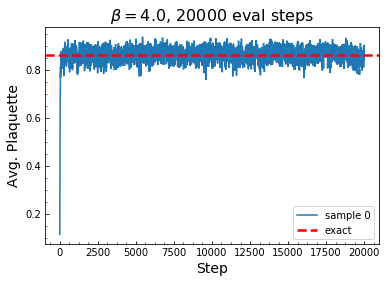

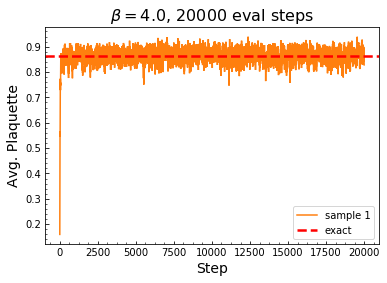

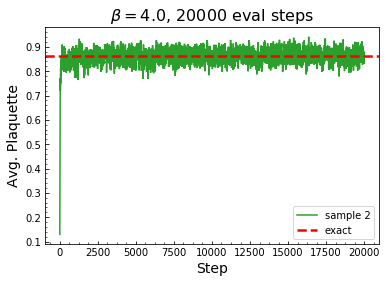

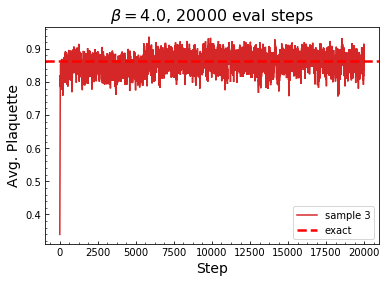

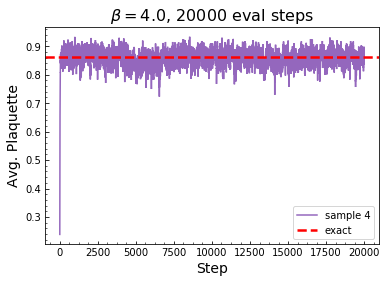

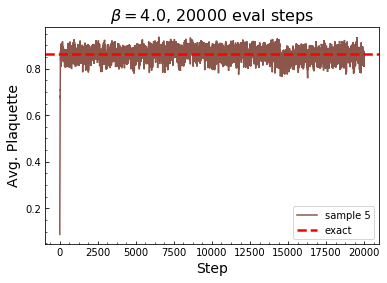

In [161]:
steps = np.arange(plaqs_arr.shape[0])
for idx in range(plaqs_arr.shape[1]):
    fig, ax = plt.subplots()
    _ = ax.plot(steps, plaqs_arr[:, idx], label=f'sample {idx}', marker='', color=COLORS[idx])
    _ = ax.axhline(y=u1_plaq_exact(4.), color='r', ls='--', lw=2.5, label='exact')
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Step', fontsize=14)
    _ = ax.set_ylabel('Avg. Plaquette', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{4.0}, {20000} eval steps")
    _ = ax.set_title(title_str, fontsize=16)
    out_file = os.path.join(log_dir, 'figures', f'avg_plaquette_sample{idx}.pdf')
    plt.savefig(out_file, dpi=400, bbox_inches='tight')
    _ = plt.show()

Text(0.5, 0, 'Step')

Text(0, 0.5, 'Avg. Plaquette')

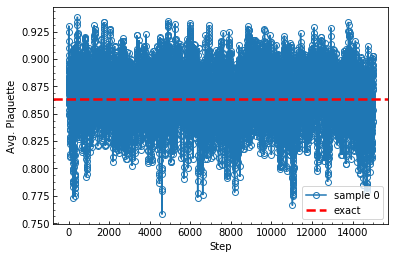

In [151]:
steps = np.arange(plaqs_arr.shape[0])
fig, ax = plt.subplots()
ax.plot(steps, plaqs_arr[:, 0], label='sample 0', marker='.', color='C0')
_ = ax.axhline(y=u1_plaq_exact(4.), color='r', ls='--', lw=2.5, label='exact')
ax.legend(loc='best')
ax.set_xlabel('Step')
ax.set_ylabel('Avg. Plaquette')
plt.show()

In [88]:
plot_observables(log_dir, observables_dicts, training=False)

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/average_action_vs_step.pdf.
--------------------------------------------------------------------------------
Saving figure to ../../gauge_logs_graph/run_225/figures/1000_steps_beta_3.0/topological_charge_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_225/figures/1000_steps_beta_3.0/average

In [89]:
plot_top_charges(log_dir, observables_dicts[-3], training=False)

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_history_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_charge_history_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_cha

In [90]:
plt.close('all')
plot_top_charges_counts(log_dir, observables_dicts[-3], training=False)

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_1.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_2.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_3.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_4.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_sample_5.pdf.
--------------------------------------------------------------------------------

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_charge_counts_sample_0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_charge_cou

In [91]:
plt.close('all')
COLORS *= 10
MARKERS *= 10
params, _, _, _, figs_dir_dict = find_samples(log_dir)
charges_dict = observables_dicts[-3]
title_str_key = 'evaluation'
count_dict = {}
idx = 0
for key, val in charges_dict.items():
    step, beta = key 
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='',
                fillstyle='full')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=16)
    #out_dir = os.path.join(
    #    figs_dir_dict[key], 'topological_charges_counts'
    #)
    #check_else_make_dir(out_dir)
    out_file = os.path.join(
       figs_dir_dict[key],
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.close('all')

Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_3.0/topological_charge_counts_total_10000_steps_beta_3.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/10000_steps_beta_4.0/topological_charge_counts_total_10000_steps_beta_4.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/1000_steps_beta_3.0/topological_charge_counts_total_1000_steps_beta_3.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/1000_steps_beta_4.0/topological_charge_counts_total_1000_steps_beta_4.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/5000_steps_beta_3.0/topological_charge_counts_total_5000_steps_beta_3.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/5000_steps_beta_4.0/topological_charge_counts_total_5000_steps_beta_4.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/500_steps_beta_3.0/topological_charge_counts_total_500_steps_beta_3.0.pdf.
Saving figure to ../../gauge_logs_graph/run_225/figures/500_steps_b

In [20]:
plt.close('all')

In [21]:
def update_beta(step, beta_init, beta_final, train_steps):
    """Returns new beta to follow annealing schedule."""
    temp = ((1. / beta_init - 1. / beta_final)
            * (1. - step / float(train_steps))
            + 1. / beta_final)
    new_beta = 1. / temp

    return new_beta

In [22]:
update_beta(500, 3., 4., 5000)

3.0769230769230775

In [90]:
def update_beta1(beta, annealing_factor, beta_final):
    new_beta = beta / annealing_factor
    if new_beta < beta_final:
        return new_beta
    return beta_final

In [83]:
def update_beta2(beta_init, beta_final, train_steps, step):
    """Returns new beta to follow annealing schedule."""
    temp = ((1. / beta_init - 1. / beta_final)
            * (1. - step / float(train_steps))
            + 1. / beta_final)
    new_beta = 1. / temp
    return new_beta

In [93]:
beta_init = 2.
beta_final = 4.
train_steps = 6931

In [94]:
betas1 = []
betas2 = []
beta1 = beta_init
for i in range(train_steps):
    beta1 = update_beta1(beta1, 0.9999, beta_final)
    beta2 = update_beta2(beta_init, beta_final, train_steps, i)
    betas1.append(beta1)
    betas2.append(beta2)
betas1 = np.array(betas1)
betas2 = np.array(betas2)

In [92]:
np.where(betas1 >= 4.)

(array([6931, 6932, 6933, ..., 9997, 9998, 9999]),)

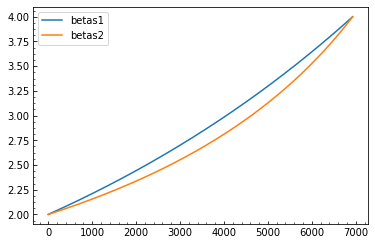

In [95]:
x = np.arange(train_steps)
fig, ax = plt.subplots()
ax.plot(x, betas1, label='betas1')
ax.plot(x, betas2, label='betas2')
ax.legend(loc='best')

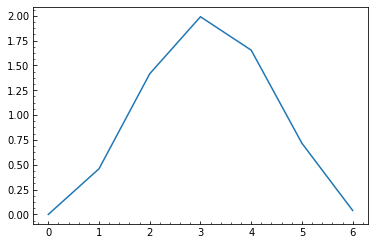

In [62]:
x = np.arange(0, 2* np.pi)
y = 1. - np.cos(x)
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

# OLD

### Topological susceptibility

$ \chi(\beta, V) \equiv \frac{\left< Q^2 \right>}{V}$

In [ ]:
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

In [ ]:
actions_dicts, plaqs_dicts, charges_dicts = observables_dicts
charges = charges_dicts[5000]

In [ ]:
test_statistic = lambda x: np.mean(x)

estimate_arr = []
bias_arr = []
stderr_arr = []
conf_interval_arr = []
for idx, sample in enumerate(charges.T):
    sample_squared = sample ** 2
    charge_rs = jackknife_resampling(sample_squared)
    estimate, bias, stderr, conf_interval = jackknife_stats(sample_squared,
                                                            test_statistic,
                                                            0.95)
    print(80 * '-' + '\n')
    print(f"Topological susceptibility statistics for sample {idx}, "
          f"consisting of {charge_rs.shape[0]} L2HMC steps.")
    print(f'estimate: {estimate}')
    print(f'bias: {bias}')
    print(f'stderr: {stderr}')
    print(f'conf_interval: {conf_interval}\n')
    print(80 * '-' + '\n')
    estimate_arr.append(estimate)
    bias_arr.append(bias)
    stderr_arr.append(stderr)
    conf_interval_arr.extend(conf_interval)

In [ ]:
test_statistic = lambda x: np.mean(x)

estimate_arr = []
bias_arr = []
stderr_arr = []
conf_interval_arr = []
for idx, sample in enumerate(charges.T):
    sample_squared = sample ** 2
    charge_rs = jackknife_resampling(sample_squared)
    estimate, bias, stderr, conf_interval = jackknife_stats(sample_squared,
                                                            test_statistic,
                                                            0.95)
    print(80 * '-' + '\n')
    print(f"Topological susceptibility statistics for sample {idx}, "
          f"consisting of {charge_rs.shape[0]} L2HMC steps.")
    print(f'estimate: {estimate}')
    print(f'bias: {bias}')
    print(f'stderr: {stderr}')
    print(f'conf_interval: {conf_interval}\n')
    print(80 * '-' + '\n')
    estimate_arr.append(estimate)
    bias_arr.append(bias)
    stderr_arr.append(stderr)
    conf_interval_arr.extend(conf_interval)

In [ ]:
charges_rs = np.array([jackknife_resampling(sample**2) for sample in charges.T])
charges_rs.shape

In [ ]:
test_statistic = lambda x: np.mean(x))

susceptibility_stats = {
    'estimate': [],
    'bias': [],
    'stderr': [],
    'conf_interval': []
}
for sample in charges_rs:
    estimate, bias, stderr, conf_interval = jackknife_stats(sample,
                                                            test_statistic,
                                                            0.95)
    susceptibility_stats['estimate'].append(estimate)
    susceptibility_stats['bias'].append(bias)
    susceptibility_stats['stderr'].append(bias)
    susceptibility_stats['conf_interval'].append(conf_interval)

In [ ]:
test_statistic = lambda x: (np.mean(x), np.var(x))
estimate, bias, stderr, conf_interval = jackknife_stats(data, 
                                                        test_statistic, 
                                                        0.95)

In [ ]:
charge_squared_mean, charge_squared_err = resampling.jackknife(
    charges, func=lambda x: x**2, func_axis=0
)

In [ ]:
%debug

In [ ]:
squared_mean_a, squared_mean_a_error = resampling.jackknife(a, func=lambda x: x**2)


In [ ]:
suscept = []
errors = []
for sample in charges.T:
    charges_rs = block_resampling(np.array(sample), 2500)
    avg_charge2_rs = []
    for block in charges_rs:
        avg_charge2_rs.append(np.mean(block ** 2))
    error = jackknife_err(y_i=avg_charge2_rs,
                          y_full=sample,
                          num_blocks=2500)
    suscept.append(np.mean(avg_charge2_rs))
    errors.append(error)

In [ ]:
charges = charges_dicts[10000]
print(np.mean(charges**2, axis=0))

In [ ]:
from lattice.lattice import GaugeLattice

In [ ]:
lattice = GaugeLattice(4, 4, 2, 'U1', 5, rand=False, data_format='channels_last')

In [ ]:
lattice_gpu = GaugeLattice(4, 4, 2, 'U1', 5, rand=False, data_format='channels_first')

In [ ]:
lattice.links.shape, lattice_gpu.links.shape

In [ ]:
lattice.samples.shape, lattice_gpu.samples.shape

In [ ]:
for key in lattice.plaquettes_dict.keys():
    print(f'channels_last  {key}: {lattice.plaquettes_dict[key]}')
    print(f'channels_first {key}: {lattice_gpu.plaquettes_dict[key]}')
    print('\n')

In [ ]:
rand_samples = np.random.randn(lattice.num_samples * lattice.num_links)
rand_links = np.random.randn(lattice.num_links)

In [ ]:
s_rand = rand_samples.reshape(lattice.samples.shape)
l_rand = rand_links.reshape(lattice.links.shape)
s_rand.shape, l_rand.shape

In [ ]:
s_rand_gpu = s_rand.transpose(0, 3, 1, 2)
l_rand_gpu = l_rand.transpose(2, 0, 1)
s_rand_gpu.shape, l_rand_gpu.shape

In [ ]:
lattice._total_action(l_rand)

In [ ]:
lattice_gpu._total_action(l_rand_gpu)

In [ ]:
for key in lattice.plaquettes_dict.keys():
    idxs0 = lattice.plaquettes_dict[key]
    idxs1 = lattice_gpu.plaquettes_dict[key]
    plaq_sum0 = [l_rand[idxs0[0]] + l_rand[idxs0[1]] 
                 - l_rand[idxs0[2]] -  l_rand[idxs0[3]]]
    plaq_sum1 = [l_rand_gpu[idxs1[0]] + l_rand_gpu[idxs1[1]] 
                 - l_rand_gpu[idxs1[2]] - l_rand_gpu[idxs1[3]]]
    print(f'plaq_sum (channels last):  {plaq_sum0}')
    print(f'plaq_sum (channels first): {plaq_sum1}')
    print('\n')

In [ ]:
print(lattice.calc_plaq_observables(s_rand, 1.))

In [ ]:
print(lattice_gpu.calc_plaq_observables(s_rand_gpu, 1.))

In [ ]:
lattice._total_action(l_rand)

In [ ]:
lattice_gpu._total_action(l_rand_gpu)

In [ ]:
links_shape = tuple([8] + [8 for _ in range(1)] + [2])
links = np.arange(lattice.num_links).reshape(links_shape)
#links = np.zeros(links_shape, dtype=np.float32)

In [ ]:
plaquettes_arr = np.array(list(lattice.plaquettes_dict.values()))

In [ ]:
print(plaquettes_arr)

In [ ]:
plaquettes_arr.shape

In [ ]:
plaquettes_arr[0, 2:, :]

In [ ]:
pos_plaquettes = plaquettes_arr[:, :2, :]
neg_plaquettes = plaquettes_arr[:, 2:, :]

In [ ]:
action, plaqs, charge = lattice._calc_plaq_observables(links, beta=1.)

In [ ]:
charge

In [ ]:
def project_angle(x):
    return x - 2 * np.pi * tf.math.floor((x + np.pi) / (2 * np.pi))

In [ ]:
pos_plaquettes[0]
np.sum(pos_plaquettes[0], axis=1)
neg_plaquettes[0]

In [ ]:
links(pos_plaquettes[0])

In [ ]:
_charge = np.sum(project_angle(np.sum(links[pos_plaquettes]) - np.sum(links[neg_plaquettes])))

In [ ]:
_charge

In [ ]:
links[0][0]

In [ ]:
links[0, 1]

In [ ]:
links.shape

In [ ]:
links[]

In [ ]:
links

In [ ]:
links = np.array(
    [[i, j, k] for i in range(8) for j in range(8) for k in range(2)]
)
links
links.shape

In [ ]:
lattice.links.shape

In [ ]:
arr = np.array(
    [[a, b, c, d] for a in range(5) for b in range(8) for c in range(8) for d in range(2)]
).reshape(lattice.samples.shape)
arr
arr.shape

In [ ]:
patches = tf.extract_image_patches(images=samples_tensor,
                                   ksizes=[1, 2, 2, 1],
                                   strides=[1, 1, 1, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='VALID')

In [ ]:
patches.shape

In [ ]:
patches[0, 

In [ ]:
  print tf.extract_image_patches(images=images, ksizes=[1, 3, 3, 1], strides=[1, 5, 5, 1], rates=[1, 1, 1, 1], padding='VALID').eval(), '\n\n'


In [ ]:
offsets = np.array(
    [(i, j) for i in range(8) for j in range(8)],  dtype=np.float32
)
offsets
offsets.shape

In [ ]:
samples_tensor = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
glimpse = tf.image.extract_glimpse(input=samples_tensor, size=(2, 2), offsets=offsets)

In [ ]:
samples_tensor.shape

## Using helpers from: `utils/gauge_observables.py`

In [ ]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

In [ ]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

In [ ]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [ ]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [ ]:
lattice.links.shape

## Calculate observables and create plots step by step, dir by dir...

In [ ]:
log_dir = '../../gauge_logs_graph/run_1/'
observables_dicts = calc_observables(log_dir)

In [ ]:
observables_dicts = calc_observables(log_dir, observables_dicts)

In [ ]:
figs_axes = plot_observables(log_dir, observables_dicts)

In [ ]:
plot_top_charges(log_dir, observables_dicts[-1])

In [ ]:
plt.close('all')

In [ ]:
batch_size = 5
forward_mask = tf.cast(
    tf.random_uniform((batch_size,)) > 0.5,
    tf.float32
)
backward_mask = 1. - forward_mask

In [ ]:
lattice = GaugeLattice(8, 8, 2, 'U1', batch_size, rand=False)
position = lattice.samples
position.shape

In [ ]:
position_mask_forward = forward_mask[:, None, None, None] * position

In [ ]:
position_mask_forward.shape

In [ ]:
forward_mask

In [ ]:
backward_mask

### OLD

In [ ]:
log_dir = (
    '../../gauge_logs_graph/run_78/'
)

figs_dir = os.path.join(log_dir, 'figures')
#autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
#check_else_make_dir(autocorr_dir)

#### Calculate observables

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

#### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [ ]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

#### Create plots

In [ ]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

In [ ]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    kwargs = {
        'figs_dir': _figs_dir
    }
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'], 
        _observables,
        **kwargs
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

In [ ]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], label=f'sample {idx}', 
                    color=COLORS[idx], marker=MARKERS[idx], fillstyle='none', 
                    ls=':', lw=0.75)
        _ = ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

In [ ]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def exp_fn(x, a, b, c, d):
    return a * np.exp(-b * (x - c))

In [ ]:
def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

In [ ]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

In [ ]:
ydata = actions[200][:, 0]
xdata = np.arange(len(ydata))

In [ ]:
A, K = fit_exp_linear(xdata, ydata, C=0)
#fit_y = model_func(t, A, K, C0)
plot(ax2, t, y, noisy_y, fit_y, (A0, K0, C0), (A, K, 0))
ax2.set_title('Linear Fit')

In [ ]:
popt, pcov = curve_fit(exp_fn, xdata, ydata)

In [ ]:
fig, ax = plt.subplots()
ax.plot(xdata, exp_fn(xdata, *popt), ls='-',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
ax.plot(xdata, ydata, marker='o', ls='', label='Sample 0')
ax.set_xlabel('Step')
ax.set_ylabel('Total action')
plt.show()

## Look at observables from samples generated during training 

In [ ]:
log_dir = '../../gauge_logs_graph/run_10/'
train_observables_dicts = calc_training_observables(log_dir)

In [ ]:
train_observables_dicts = calc_training_observables(log_dir, 
                                                    train_observables_dicts)

In [ ]:
figs_axes = plot_training_observables(log_dir, train_observables_dicts)

In [ ]:
#actions_dict, plaqs_dict, charges_dict = train_observables_dicts
plot_top_charges_training(log_dir, train_observables_dicts[-1])

### OLD

In [ ]:
from utils.gauge_observables import (
    _load_samples_from_file, _load_params, _calc_observables,
)

In [ ]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 50,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

In [ ]:
log_dir = '../../gauge_logs_graph/run_63/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 100,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

In [ ]:
log_dir = '../../gauge_logs_graph/run_78/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

#save_params_to_pkl_file(params, info_dir)

params = _load_params(log_dir)

figs_dir = os.path.join(log_dir, 'figures')
samples_dict, actions_dict, plaqs_dict, charges_dict = {}, {}, {}, {}

In [ ]:
train_samples_files = [train_samples_dir + i 
                       for i in os.listdir(train_samples_dir) 
                       if i.endswith('.pkl')]
train_samples_files

In [ ]:
step_keys = sorted(
    [int(i.split('/')[-1].split('_')[2]) for i in train_samples_files]
)
step_keys

In [ ]:
training_figs_dir = os.path.join(figs_dir, 'training/')
check_else_make_dir(training_figs_dir)
training_steps_figs_dir = {}

for key in step_keys:
    _dir = os.path.join(training_figs_dir, f'{key}_train_steps/')
    check_else_make_dir(_dir)
    training_steps_figs_dir[key] = _dir

In [ ]:
for idx, sample_file in enumerate(train_samples_files):
    step = step_keys[idx]
    if step not in charges_dict.keys():
        print(f"Calculating observables for {step}...")
        with open(sample_file, 'rb') as f:
            samples = pickle.load(f)

        actions, plaqs, charges = _calc_observables(samples, params)

        actions_dict[step] = actions
        plaqs_dict[step] = plaqs
        charges_dict[step] = charges

In [ ]:
for key in charges_dict.keys():
    actions = actions_dict[key]
    plaqs = plaqs_dict[key]
    charges = charges_dict[key]
    observables = (actions, plaqs, charges)
    
    title_str = (r"$\beta =$"
                 + f"{params['beta_final']}, {key} training steps")
    
    kwargs = {
        'figs_dir': training_steps_figs_dir[key],
        'title': title_str
    }
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'],  
        observables, 
        **kwargs
    )

In [ ]:
plt.close('all')
for key, val in charges_dict.items():
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], 
                    marker=MARKERS[idx], color=COLORS[idx], 
                    ls='', fillstyle='none', label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        title_str = (r"$\beta =$"
                     + f"{params['beta_final']}, {key} training steps")
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(training_steps_figs_dir[key],
                                f'topological_charge_history_sample_{idx}.pdf')
        if not os.path.isfile(out_file):
            print(f"Saving figure to: {out_file}.")
            _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
        
        #_ = ax.set_title(fr"""$\beta =$ {params['beta_final']},"""
        #                 fr""" {key} training steps""")
                         

## Modifying lattice structure

In [ ]:
from lattice.lattice import GaugeLattice

In [ ]:
lattice = GaugeLattice(8, 8, 2, 'U1', 5, False)

In [ ]:
lattice.links.shape

In [ ]:
sample = lattice.samples[0]

In [ ]:
sample

In [ ]:
lattice.sites

In [ ]:
links_arr = np.arange(lattice.num_links).reshape(sample.shape)
sites_arr = np.arange(lattice.num_sites).reshape(lattice.sites.shape)

In [ ]:
sites_arr = np.array(lattice.num_sites * ['o']).reshape(lattice.sites.shape)

In [ ]:
print(sites_arr)
print(sites_arr.shape)

In [ ]:
print(links_arr.T)
print(links_arr.T.shape)

In [ ]:
print(links_arr)

## OLD PLOTS

In [ ]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

In [ ]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
plt.close('all')

In [ ]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

## OLD

In [ ]:
np.mean(ESS_arr)

In [ ]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [ ]:
lattice.num_links

##### Old approach (unsure of validity)

In [ ]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [ ]:
iac2, iac4, iac10

In [ ]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})